In [1]:
%cd open-images

/mnt/data/object_detection/open-images


In [8]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from tqdm import tqdm
import os
import glob
import re
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

In [14]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(im)
    plt.axis('off');

## 1. Register Datasets

In [3]:
def bbox_rel_to_abs(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Args:
        bbox (array): relative bounding box in format (x0, x1, y0, y1)
        height (int): height of image
        width (int): width of image
    Return:
        List of absolute bounding box values in format (x0, y0, x1, y1)
    """
    x0 = np.round(np.multiply(bbox[0], width))
    x1 = np.round(np.multiply(bbox[1], width))
    y0 = np.round(np.multiply(bbox[2], height))
    y1 = np.round(np.multiply(bbox[3], height))
    return [x0, y0, x1, y1]

In [4]:
def get_detectron_dicts(img_dir):
    """
    Create a Detectron2's standard dataset dicts from an image folder.
    See: https://detectron2.readthedocs.io/tutorials/datasets.html
    
    Args:
        img_dir (str): path to the image folder (train/validation)
    Return:
        dataset_dicts (list[dict]): List of annotation dictionaries for Detectron2.
    """
    
    # Load annotation DataFrame
    annot_df = pd.read_csv(f"{img_dir}-annotations-bbox-truncated.csv")
    
    # Get all images in `img_dir`
    img_paths = glob.glob(f'{img_dir}/*.jpg')
    
    dataset_dicts = []
    for path in tqdm(img_paths):
        file_name = path
        height, width = cv2.imread(file_name).shape[:2]
        # Get image id from file_name
        img_id = re.findall(f"{img_dir}/(.*).jpg", file_name)[0]
            
        record = {}
        record['file_name'] = file_name
        record['image_id'] = img_id
        record['height'] = height
        record['width'] = width
        
        # Extract bboxes from annotation file
        bboxes = annot_df[['ClassID', 'XMin', 'XMax', 'YMin','YMax']][annot_df['ImageID'] == img_id].values
        annots = []
        for bbox in bboxes:
            # Calculate absolute bounding box
            abs_bbox = bbox_rel_to_abs(bbox[1:], height, width)
            annot = {
                "bbox": abs_bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(bbox[0]),
            }
            annots.append(annot)

        record["annotations"] = annots
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
# Specify target classes and create `class2id` dictionary
target_classes = ['Camera', 'Tripod']
class2id = {class_: id_ for id_, class_ in enumerate(target_classes)}

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog

for d in ["train", "validation"]:
    dataset_name = "camera_tripod_" + d
    print("Registering ", dataset_name)
    DatasetCatalog.register(dataset_name, lambda d=d: get_detectron_dicts("./" + d))
    MetadataCatalog.get(dataset_name).set(thing_classes=target_classes)

detectron_metadata = MetadataCatalog.get("camera_tripod_train")

Registering  camera_tripod_train
Registering  camera_tripod_validation


## 2. Train

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("camera_tripod_train",)
cfg.DATASETS.TEST = ("camera_tripod_validation",)
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## 3. Inference & evaluation using the trained model

### 3.1. Inference

In [33]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("camera_tripod_validation",)
predictor = DefaultPredictor(cfg)

In [26]:
dataset_dicts = get_detectron_dicts("validation")

100%|██████████| 166/166 [00:02<00:00, 69.24it/s]


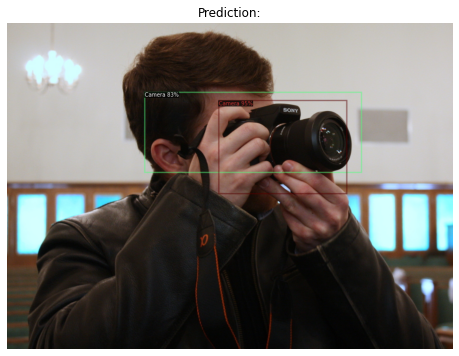

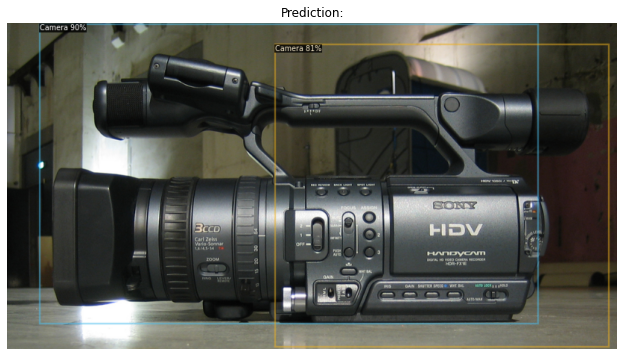

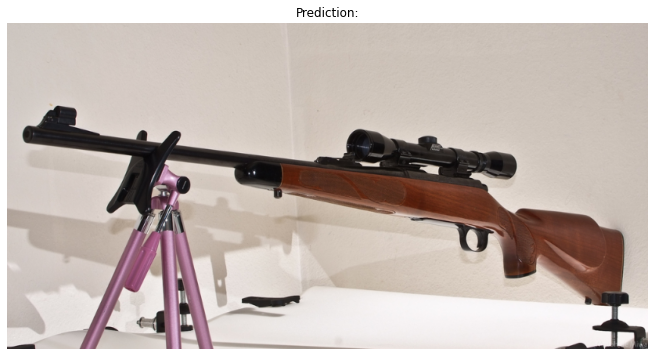

In [38]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=detectron_metadata, 
                   scale=0.8)
    pred = v.draw_instance_predictions(outputs["instances"][:2].to("cpu"))
    cv2_imshow(pred.get_image()[:, :, ::-1])
    plt.title("Prediction:")

### 3.2. Evaluation

In [40]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("camera_tripod_validation", cfg, False, output_dir="./output/")
trainer.test(cfg=cfg,
             model=trainer.model,
             evaluators=evaluator)

100%|██████████| 166/166 [00:02<00:00, 67.99it/s]

[06/23 22:14:23 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[06/23 22:14:23 d2.data.common]: Serialized dataset takes 0.06 MiB
[06/23 22:14:23 d2.evaluation.evaluator]: Start inference on 166 images


[06/23 22:14:24 d2.evaluation.evaluator]: Inference done 11/166. 0.0400 s / img. ETA=0:00:06
[06/23 22:14:29 d2.evaluation.evaluator]: Inference done 134/166. 0.0391 s / img. ETA=0:00:01
[06/23 22:14:30 d2.evaluation.evaluator]: Total inference time: 0:00:06.614650 (0.041085 s / img per device, on 1 devices)
[06/23 22:14:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.039064 s / img per device, on 1 devices)
[06/23 22:14:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/23 22:14:30 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/23 22:14:30 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.232
 Aver

OrderedDict([('bbox',
              {'AP': 23.208270463462796,
               'AP50': 47.27365456529358,
               'AP75': 20.844134692096045,
               'APs': nan,
               'APm': 15.297458317260299,
               'APl': 23.973142020898422,
               'AP-Camera': 39.09153436668289,
               'AP-Tripod': 7.325006560242697})])